## Project goal

This notebook explores various ways of detecting whether a transaction is fraudulent. The goal is to build a machine learning model that detects frauds accurately and minimizes false postives. To achive that it is crucial to handle data imbalance which is common in fraud detection problems. 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import xgboost as xgb

from scipy.stats import randint, uniform

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import shap

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

Data was sourced from Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

This creditcard.csv is made available under the Open Database License: http://opendatacommons.org/licenses/odbl/1.0/. Any rights in individual contents of the database are licensed under the Database Contents License: http://opendatacommons.org/licenses/dbcl/1.0/


In [2]:
credit_card_scaled = pd.read_parquet("credit_card_scaled.parquet")

Why do we create a sub-Sample?
In the beginning of this notebook we saw that the original dataframe was heavily imbalanced! Using the original dataframe will cause the following issues:

Overfitting: Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs.
Wrong Correlations: Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.
Subsampling a training set, either undersampling or oversampling the appropriate class or classes, can be a helpful approach to dealing with classification data where one or more classes occur very infrequently. In such a situation (without compensating for it), most models will overfit to the majority class and produce very good statistics for the class containing the frequently occurring classes while the minority classes have poor performance.

random under-sample and SMOTE and Cost-Sensitive Learning

Random Forest (RF) and Decision Trees - they can handle imbalanced data because of their inherent ability to find decision boundaries that separate classes well.
Ensemble methods like AdaBoost, rfoost, LightGBM, or CatBoost, Bagging, or Stacking with base learners that handle imbalanced data well can be quite effective.

Anomaly detection is a specialized technique for handling data imbalance in
machine learning, particularly when one class (the anomaly or rare event) is
vastly outnumbered by the other class (normal or majority class).
K-Means Clustering, Isolation Forest is a tree-based method that isolates anomalies by creating a random forest of decision trees. Anomalies
are expected to require fewer splits to be isolated

random under-sample

In [4]:
X = credit_card_scaled.drop(columns=["Class"])
y = credit_card_scaled["Class"]

# Train (80%) and Test (20%) from original data set before undersampling 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11, stratify=y
)


In [5]:
print(X_train.shape, X_test.shape)
print(y_train.value_counts())
print(y_train.value_counts()/y_train.count())
print(y_test.value_counts())
print(y_test.value_counts()/y_test.count())

(227845, 30) (56962, 30)
Class
0    227451
1       394
Name: count, dtype: int64
Class
0    0.998271
1    0.001729
Name: count, dtype: float64
Class
0    56864
1       98
Name: count, dtype: int64
Class
0    0.99828
1    0.00172
Name: count, dtype: float64


In [6]:
frauds = credit_card_scaled[credit_card_scaled.Class == 1]
no_frauds = credit_card_scaled[credit_card_scaled.Class == 0]

In [7]:
undersample_df = pd.concat([frauds, no_frauds.sample(n=len(frauds), random_state=11)])
undersample_df["Class"].value_counts()

Class
1    492
0    492
Name: count, dtype: int64

In [8]:
# shuffling data
undersample_df = undersample_df.sample(frac=1, random_state=11)

The "average_precision" scoring metric (also known as area under the precision-recall curve) is particularly well-suited for fraud detection because:

It focuses specifically on the positive class (fraud) performance
It evaluates the model across different classification thresholds
It isn't influenced by the large number of true negatives that dominate in highly imbalanced datasets

This metric will help you find model parameters that maximize your ability to detect fraud cases while minimizing false positives, which is exactly what you want for this type of problem.

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
# X and y for undersample: 
X_us = undersample_df.drop(columns=["Class"]) 
y_us = undersample_df["Class"]

X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size=0.3, random_state= 11, stratify=y_us)

results_us_test = []

rf_search_space = {
    'n_estimators': range(10, 101),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 51),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

xgb_search_space = {
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.1),
    "n_estimators": randint(100, 1000),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
}
    
rf_model_us = RandomForestClassifier()
search_rf_us = RandomizedSearchCV(n_iter=50, estimator= rf_model_us, param_distributions=rf_search_space,
                              cv= skf, verbose= 2, n_jobs= -1, scoring="balanced_accuracy")
search_rf_us.fit(X_train_us, y_train_us)

params_rf_us = search_rf_us.best_params_
best_rf_us = RandomForestClassifier(**params_rf_us)
best_rf_us.fit(X_train_us, y_train_us)
pred_rf_us = best_rf_us.predict(X_test_us)

xgb_model_us = xgb.XGBClassifier()
search_xgb_us = RandomizedSearchCV(n_iter=50, estimator= xgb_model_us, param_distributions=xgb_search_space,
                              cv= skf, verbose= 2, n_jobs= -1, scoring="balanced_accuracy")
search_xgb_us.fit(X_train_us, y_train_us)
params_xgb_us = search_xgb_us.best_params_
best_xgb_us = xgb.XGBClassifier(**params_xgb_us)
best_xgb_us.fit(X_train_us, y_train_us)
pred_xgb_us = best_xgb_us.predict(X_test_us)


In [ ]:
print("Results for Random Forest model with undersampling on undersampled test: ")
print(classification_report(y_test_us, pred_rf_us))
plt = ConfusionMatrixDisplay(confusion_matrix(y_test_us, pred_rf_us))
plt.plot()



In [ ]:
print("Results for XGBoost model with undersampling on undersampled test: ")
print(classification_report(y_test_us, pred_xgb_us))
plt = ConfusionMatrixDisplay(confusion_matrix(y_test_us, pred_xgb_us))
plt.plot()

In [ ]:
pred_rf_us_original = best_rf_us.predict(X_test)

print("Results for Random Forest model with undersampling on original test: ")
print(classification_report(y_test, pred_rf_us_original))
plt = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_rf_us_original))
plt.plot()

In [ ]:
pred_xgb_us_original = best_xgb_us.predict(X_test)

print("Results for XGBoost model with undersampling on original test: ")
print(classification_report(y_test, pred_xgb_us_original))
plt = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_xgb_us_original))
plt.plot()

In [ ]:
for i in range(3):
    tree = best_rf_us.estimators_[i]
    dot_data = export_graphviz(
        tree,
        feature_names=X_train.columns,
        filled=True,
        max_depth=2,
        impurity=False,
        proportion=True,
    )
    graph = graphviz.Source(dot_data)
    display(graph)

SMOTE

In [ ]:
skf = StratifiedKFold(n_splits=5)
sm = SMOTE()

# pipeline_rf = Pipeline([('over', SMOTE()), ('model', RandomForestClassifier())]) 
# za ciezkie dla mojego kompa :(
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)


rf_search_space = {
    'n_estimators': range(10, 101),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 51),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
# rf_search_space = {
#     'model__n_estimators': range(10, 101),
#     'model__criterion': ['gini', 'entropy'],
#     'model__max_depth': range(2, 51),
#     'model__min_samples_split': range(2, 11),
#     'model__min_samples_leaf': range(1, 11),
#     'model__max_features': ['sqrt', 'log2', None],
#     'model__bootstrap': [True, False]
# }


rf_model = RandomForestClassifier()

random_search_smote_rf = RandomizedSearchCV(n_iter=10, 
                                            # estimator= pipeline_rf,
                                            estimator= rf_model,
                                             param_distributions=rf_search_space,
                              cv= skf, verbose= 3, n_jobs= -1, scoring="f1")

random_search_smote_rf.fit(X=X_train_smote, y=y_train_smote)


In [ ]:
params_smote_rf = random_search_smote_rf.best_params_
best_score_train_smote = random_search_smote_rf.best_score_

best_rf_smote = RandomForestClassifier(**params_smote_rf)
best_rf_smote.fit(X_train_smote, y_train_smote)
pred_rf_smote = best_rf_smote.predict(X_test)

In [12]:
# I will be using X, y from original data and only applying SMOTE to training data
skf = StratifiedKFold(n_splits=3)
sm = SMOTE()
pipeline_xgb = Pipeline([('over', SMOTE()), ('model', xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0))])

results_us_test = []

xgb_search_space = {
    "model__max_depth": randint(3, 10),
    "model__learning_rate": uniform(0.01, 0.1),
    "model__n_estimators": randint(100, 1000),
    "model__subsample": uniform(0.5, 0.5),
    "model__colsample_bytree": uniform(0.5, 0.5),
}
   

xgb_model = xgb.XGBClassifier()
search_xgb_smote = RandomizedSearchCV(n_iter=10, estimator= pipeline_xgb, param_distributions=xgb_search_space,
                              cv= skf, verbose= 3, n_jobs= 1, scoring="average_precision")
search_xgb_smote.fit(X_train, y_train)
params_xgb_smote = search_xgb_smote.best_params_
score_train_smote_xgb = search_xgb_smote.best_score_

best_xgb_smote = xgb.XGBClassifier(**params_xgb_smote)
best_xgb_smote.fit(X_train, y_train)
pred_xgb_smote = best_xgb_smote.predict(X_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:03:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 1/3] END model__colsample_bytree=0.9067824678298482, model__learning_rate=0.06825937849566466, model__max_depth=3, model__n_estimators=561, model__subsample=0.9707728500238766;, score=0.801 total time=   6.7s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:03:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 2/3] END model__colsample_bytree=0.9067824678298482, model__learning_rate=0.06825937849566466, model__max_depth=3, model__n_estimators=561, model__subsample=0.9707728500238766;, score=0.845 total time=   5.9s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:03:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 3/3] END model__colsample_bytree=0.9067824678298482, model__learning_rate=0.06825937849566466, model__max_depth=3, model__n_estimators=561, model__subsample=0.9707728500238766;, score=0.822 total time=   5.7s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:03:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 1/3] END model__colsample_bytree=0.9718220617402509, model__learning_rate=0.061468641112949716, model__max_depth=9, model__n_estimators=807, model__subsample=0.7617323063705121;, score=0.822 total time=  13.7s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:04:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 2/3] END model__colsample_bytree=0.9718220617402509, model__learning_rate=0.061468641112949716, model__max_depth=9, model__n_estimators=807, model__subsample=0.7617323063705121;, score=0.857 total time=  14.5s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:04:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 3/3] END model__colsample_bytree=0.9718220617402509, model__learning_rate=0.061468641112949716, model__max_depth=9, model__n_estimators=807, model__subsample=0.7617323063705121;, score=0.834 total time=  14.0s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:04:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 1/3] END model__colsample_bytree=0.5802988154542226, model__learning_rate=0.026324736742575898, model__max_depth=3, model__n_estimators=986, model__subsample=0.5750000499237562;, score=0.804 total time=   9.5s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:04:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 2/3] END model__colsample_bytree=0.5802988154542226, model__learning_rate=0.026324736742575898, model__max_depth=3, model__n_estimators=986, model__subsample=0.5750000499237562;, score=0.830 total time=   9.7s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:04:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 3/3] END model__colsample_bytree=0.5802988154542226, model__learning_rate=0.026324736742575898, model__max_depth=3, model__n_estimators=986, model__subsample=0.5750000499237562;, score=0.825 total time=  10.1s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:04:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 1/3] END model__colsample_bytree=0.5141282846881907, model__learning_rate=0.06834439948939586, model__max_depth=3, model__n_estimators=351, model__subsample=0.6952425664719846;, score=0.803 total time=   4.2s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:04:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 2/3] END model__colsample_bytree=0.5141282846881907, model__learning_rate=0.06834439948939586, model__max_depth=3, model__n_estimators=351, model__subsample=0.6952425664719846;, score=0.824 total time=   4.2s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:04:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 3/3] END model__colsample_bytree=0.5141282846881907, model__learning_rate=0.06834439948939586, model__max_depth=3, model__n_estimators=351, model__subsample=0.6952425664719846;, score=0.836 total time=   4.3s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:05:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:05:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 1/3] END model__colsample_bytree=0.7427285370926036, model__learning_rate=0.09474156399608046, model__max_depth=7, model__n_estimators=996, model__subsample=0.8946070678836184;, score=0.815 total time=  15.8s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:05:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:05:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 2/3] END model__colsample_bytree=0.7427285370926036, model__learning_rate=0.09474156399608046, model__max_depth=7, model__n_estimators=996, model__subsample=0.8946070678836184;, score=0.868 total time=  17.1s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:05:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:05:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 3/3] END model__colsample_bytree=0.7427285370926036, model__learning_rate=0.09474156399608046, model__max_depth=7, model__n_estimators=996, model__subsample=0.8946070678836184;, score=0.839 total time=  17.0s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:05:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:06:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 1/3] END model__colsample_bytree=0.9889594223976186, model__learning_rate=0.02734192126904244, model__max_depth=8, model__n_estimators=739, model__subsample=0.8614599029963854;, score=0.820 total time=  16.5s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:06:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 2/3] END model__colsample_bytree=0.9889594223976186, model__learning_rate=0.02734192126904244, model__max_depth=8, model__n_estimators=739, model__subsample=0.8614599029963854;, score=0.858 total time=  16.7s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:06:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 3/3] END model__colsample_bytree=0.9889594223976186, model__learning_rate=0.02734192126904244, model__max_depth=8, model__n_estimators=739, model__subsample=0.8614599029963854;, score=0.835 total time=  17.2s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:06:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 1/3] END model__colsample_bytree=0.9660688328321163, model__learning_rate=0.03827457340873274, model__max_depth=3, model__n_estimators=405, model__subsample=0.7796218981720577;, score=0.796 total time=   5.2s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:06:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 2/3] END model__colsample_bytree=0.9660688328321163, model__learning_rate=0.03827457340873274, model__max_depth=3, model__n_estimators=405, model__subsample=0.7796218981720577;, score=0.777 total time=   5.1s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:06:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 3/3] END model__colsample_bytree=0.9660688328321163, model__learning_rate=0.03827457340873274, model__max_depth=3, model__n_estimators=405, model__subsample=0.7796218981720577;, score=0.818 total time=   5.0s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:07:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 1/3] END model__colsample_bytree=0.9441934758209378, model__learning_rate=0.0929089537709277, model__max_depth=8, model__n_estimators=957, model__subsample=0.9196199957988689;, score=0.819 total time=  16.2s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:07:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 2/3] END model__colsample_bytree=0.9441934758209378, model__learning_rate=0.0929089537709277, model__max_depth=8, model__n_estimators=957, model__subsample=0.9196199957988689;, score=0.857 total time=  17.3s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:07:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 3/3] END model__colsample_bytree=0.9441934758209378, model__learning_rate=0.0929089537709277, model__max_depth=8, model__n_estimators=957, model__subsample=0.9196199957988689;, score=0.840 total time=  16.7s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:07:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 1/3] END model__colsample_bytree=0.8183167164555288, model__learning_rate=0.05003266212462053, model__max_depth=8, model__n_estimators=279, model__subsample=0.524210174252318;, score=0.818 total time=   6.6s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:08:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 2/3] END model__colsample_bytree=0.8183167164555288, model__learning_rate=0.05003266212462053, model__max_depth=8, model__n_estimators=279, model__subsample=0.524210174252318;, score=0.859 total time=   6.9s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:08:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:08:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 3/3] END model__colsample_bytree=0.8183167164555288, model__learning_rate=0.05003266212462053, model__max_depth=8, model__n_estimators=279, model__subsample=0.524210174252318;, score=0.835 total time=   6.8s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:08:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:08:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 1/3] END model__colsample_bytree=0.9782554846500664, model__learning_rate=0.09333957252774504, model__max_depth=9, model__n_estimators=988, model__subsample=0.9036913624975312;, score=0.820 total time=  17.8s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:08:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:08:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 2/3] END model__colsample_bytree=0.9782554846500664, model__learning_rate=0.09333957252774504, model__max_depth=9, model__n_estimators=988, model__subsample=0.9036913624975312;, score=0.860 total time=  18.6s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:08:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:09:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV 3/3] END model__colsample_bytree=0.9782554846500664, model__learning_rate=0.09333957252774504, model__max_depth=9, model__n_estimators=988, model__subsample=0.9036913624975312;, score=0.836 total time=  17.2s


c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:09:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ola\Documents\Projekty\credit_card_fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:09:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [13]:
score_train_smote_xgb

np.float64(0.8408401027861784)

Results for XGBoost model with smote on original test: 
0.8074837701661896
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.84      0.90        98

    accuracy                           1.00     56962
   macro avg       0.98      0.92      0.95     56962
weighted avg       1.00      1.00      1.00     56962



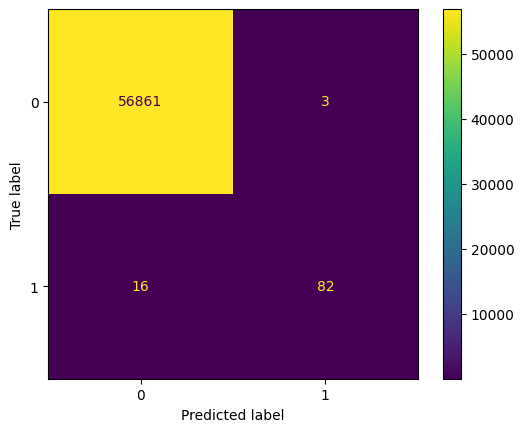

In [18]:
print("Results for XGBoost model with smote on original test: ")

print(average_precision_score(y_test, pred_xgb_smote))
print(classification_report(y_test, pred_xgb_smote))
plt = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_xgb_smote))
plt.plot()


Cost-Sensitive Learning